In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.manifold import TSNE
from umap import UMAP

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# change to %matplotlib notebook to rotate plots
%matplotlib inline 
plt.rcParams.update({'font.size': 20, 'axes.titley':1})

# Merged

In [2]:
data = defaultdict(dict)

RARITY_THRESHOLD = 0.01
STD_THRESHOLD = 1e-3

tax = 'g'
df_AGP = pd.read_csv(f'./data_processed_pat0.7/AGP_{tax}.csv', delimiter=',', index_col=0)
df_HMP = pd.read_csv(f'./data_processed_pat0.7/HMP_{tax}.csv', delimiter=',', index_col=0)

n_AGP = df_AGP.shape[0]
n_HMP = df_HMP.shape[0]
y = np.zeros(n_AGP + n_HMP)
y[n_AGP:] = 1
df = pd.merge(df_AGP, df_HMP, how = 'outer', sort=True).fillna(0)
N = df.shape[0]

# t-SNE

In [3]:
vis_root = f'results/vis_pat0.7/'

if not os.path.exists(vis_root):
    os.makedirs(vis_root)

In [4]:
tsne_path = os.path.join(vis_root, f'tsne_3d_merged_tax-{tax}')

if os.path.isfile(tsne_path + '.npy'):
    Z_tsne = np.load(tsne_path + '.npy', allow_pickle=True)
else:

    tsne = mTSNE(n_components=3, 
                perplexity=35,
                angle=0.5, 
                early_exaggeration=18,
                n_jobs=-1, 
                n_iter=1000,
                random_state=42)

    Z_tsne = tsne.fit_transform(df)
    np.save(tsne_path, Z_tsne)

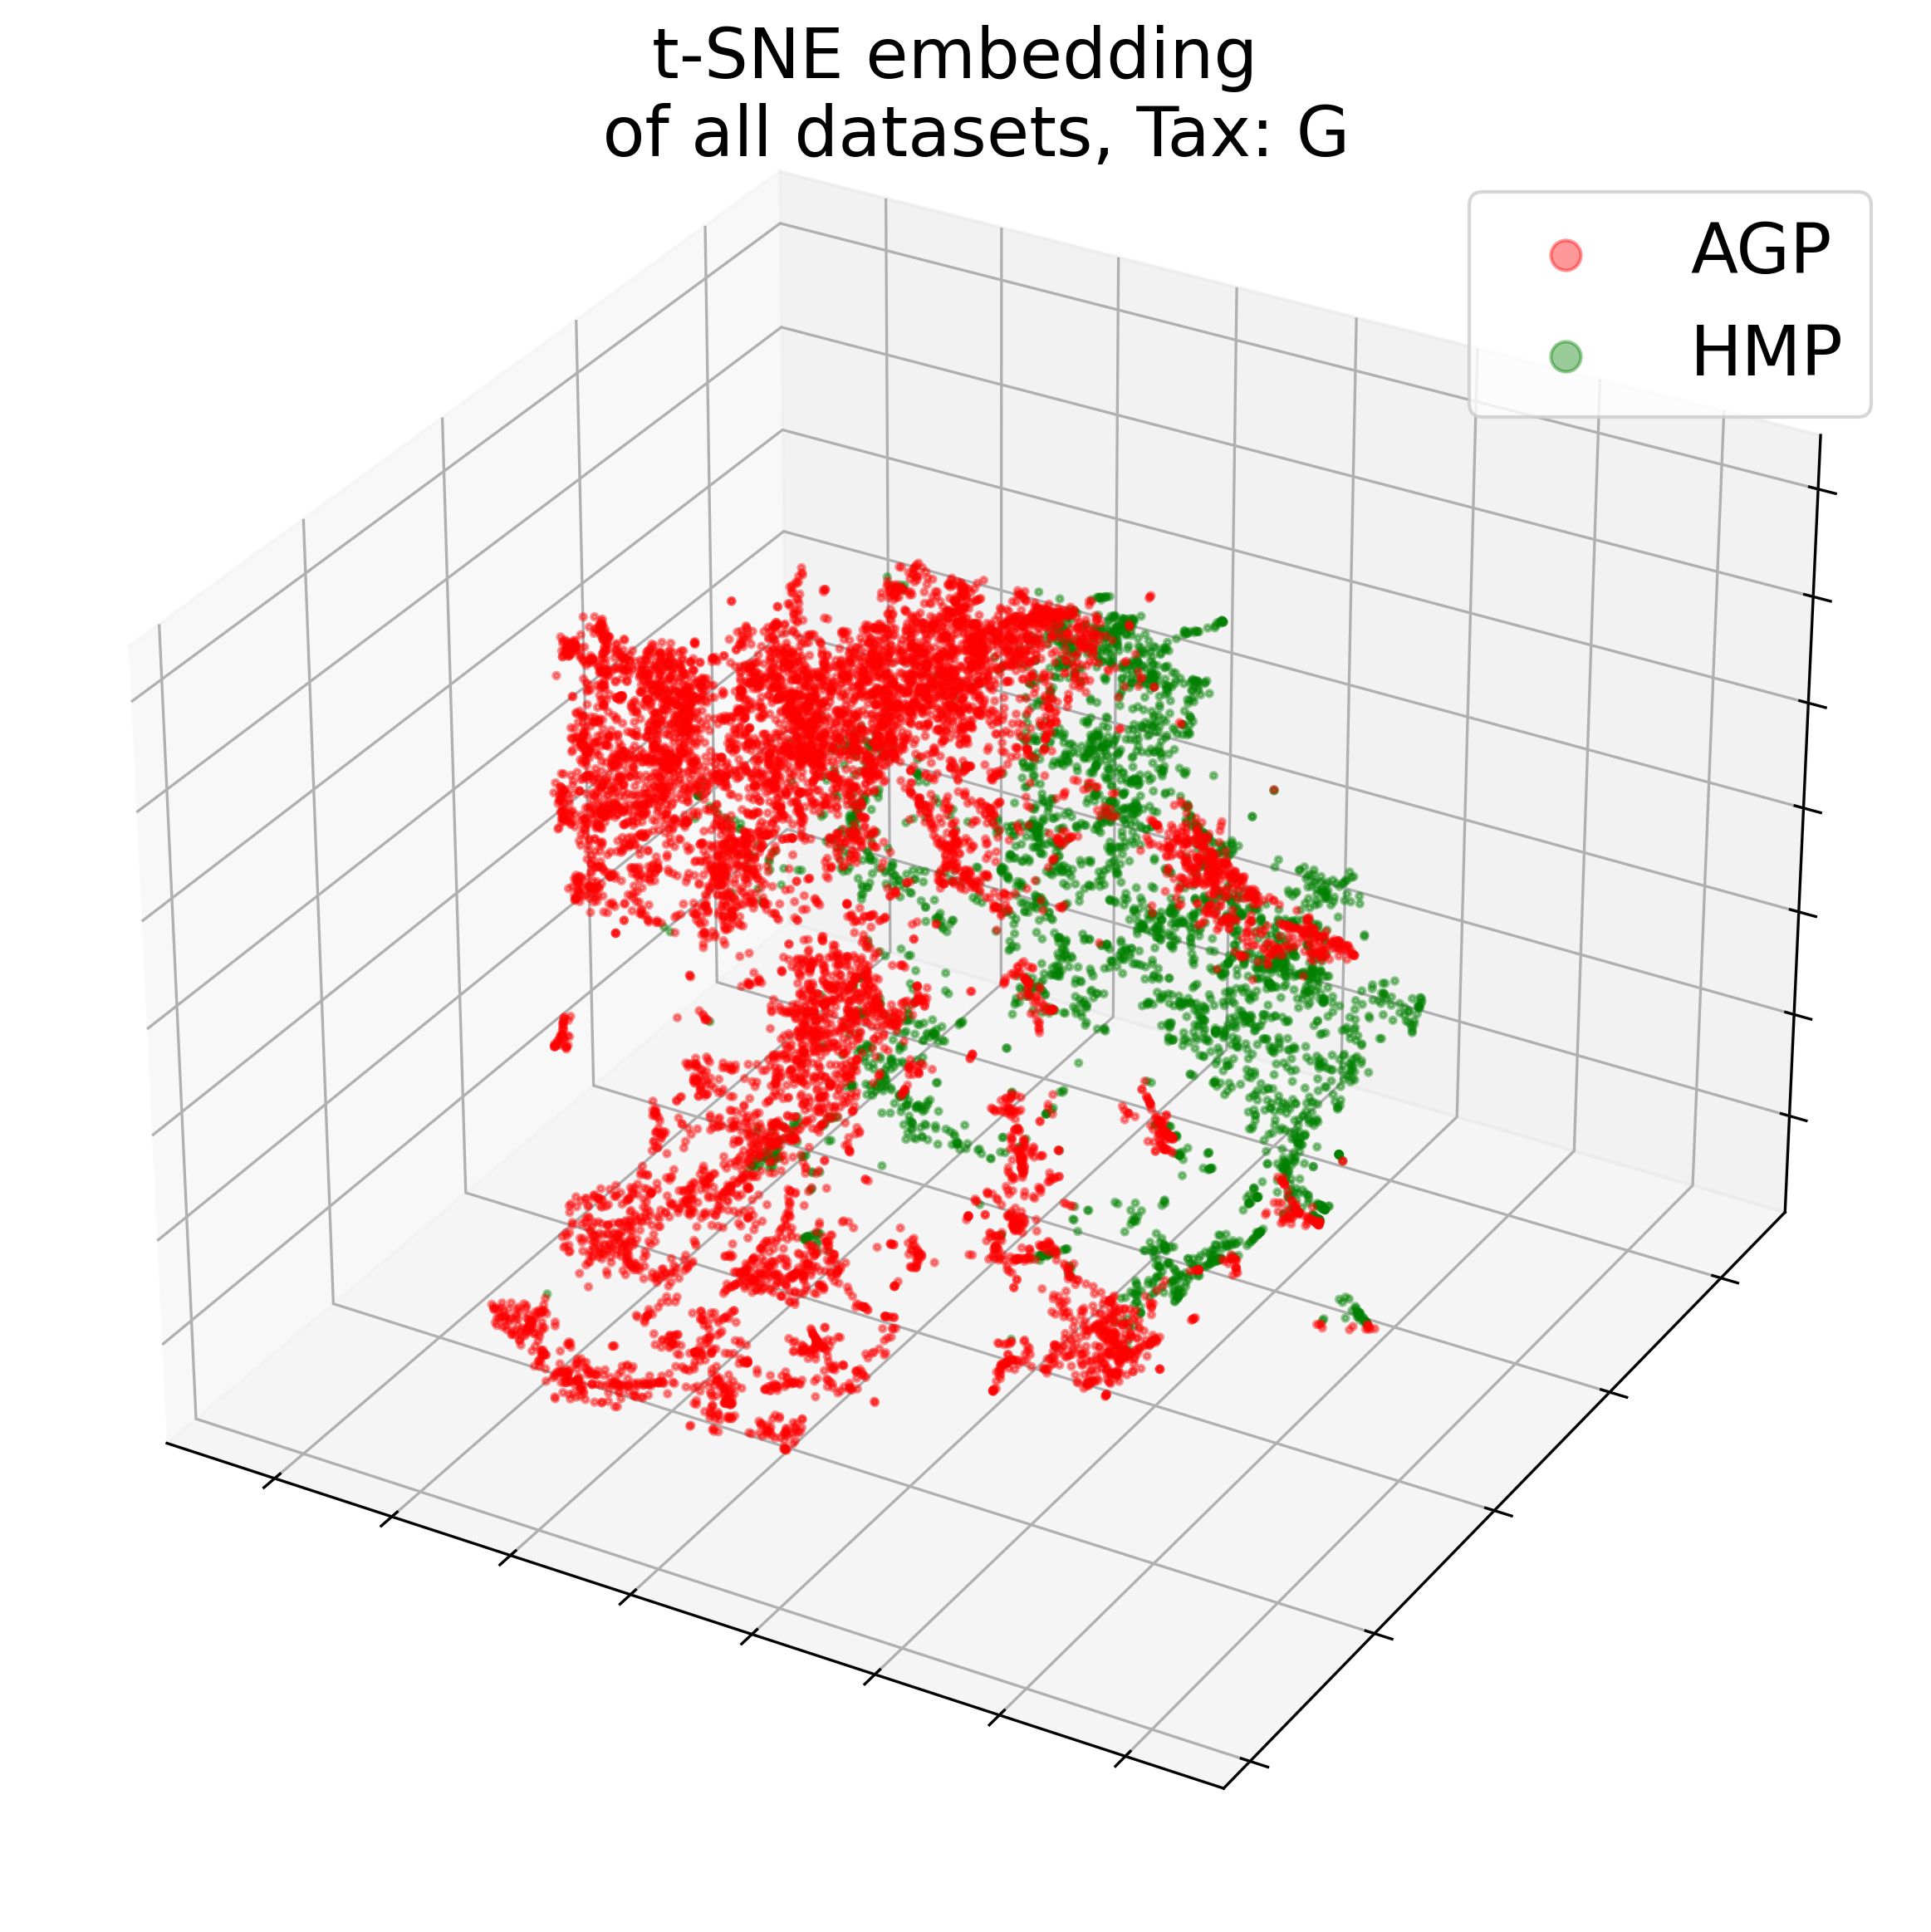

In [5]:
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.axes(projection="3d")
Z = Z_tsne
AGP_mask = np.arange(Z.shape[0]) < 9511
ax.scatter3D(Z[:, 0][AGP_mask], Z[:, 1][AGP_mask], Z[:, 2][AGP_mask], color = 'red', s = 3, label='AGP', alpha=0.4)
ax.scatter3D(Z[:, 0][~AGP_mask], Z[:, 1][~AGP_mask], Z[:, 2][~AGP_mask], color = 'green', s = 3, label='HMP',alpha=0.4)
plt.title(f"t-SNE embedding \n of all datasets, Tax: {tax.capitalize()}", fontsize=20)
plt.legend(markerscale=5, bbox_to_anchor=(1.0, 0.93)) 
ax.set_zticklabels([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True)
plt.show()

In [6]:
Z_umap = UMAP(n_neighbors=40, 
              n_components=3,
              n_epochs=1000,
              min_dist=0.0, 
              learning_rate=1, 
              n_jobs=-1,
              random_state=42).fit_transform(df)
np.save(os.path.join(vis_root, f'umap_3d_merged_tax-{tax}'), Z_umap)

In [7]:
lof_mask = LocalOutlierFactor(n_neighbors=30, contamination=0.15).fit_predict(Z_umap) == 1

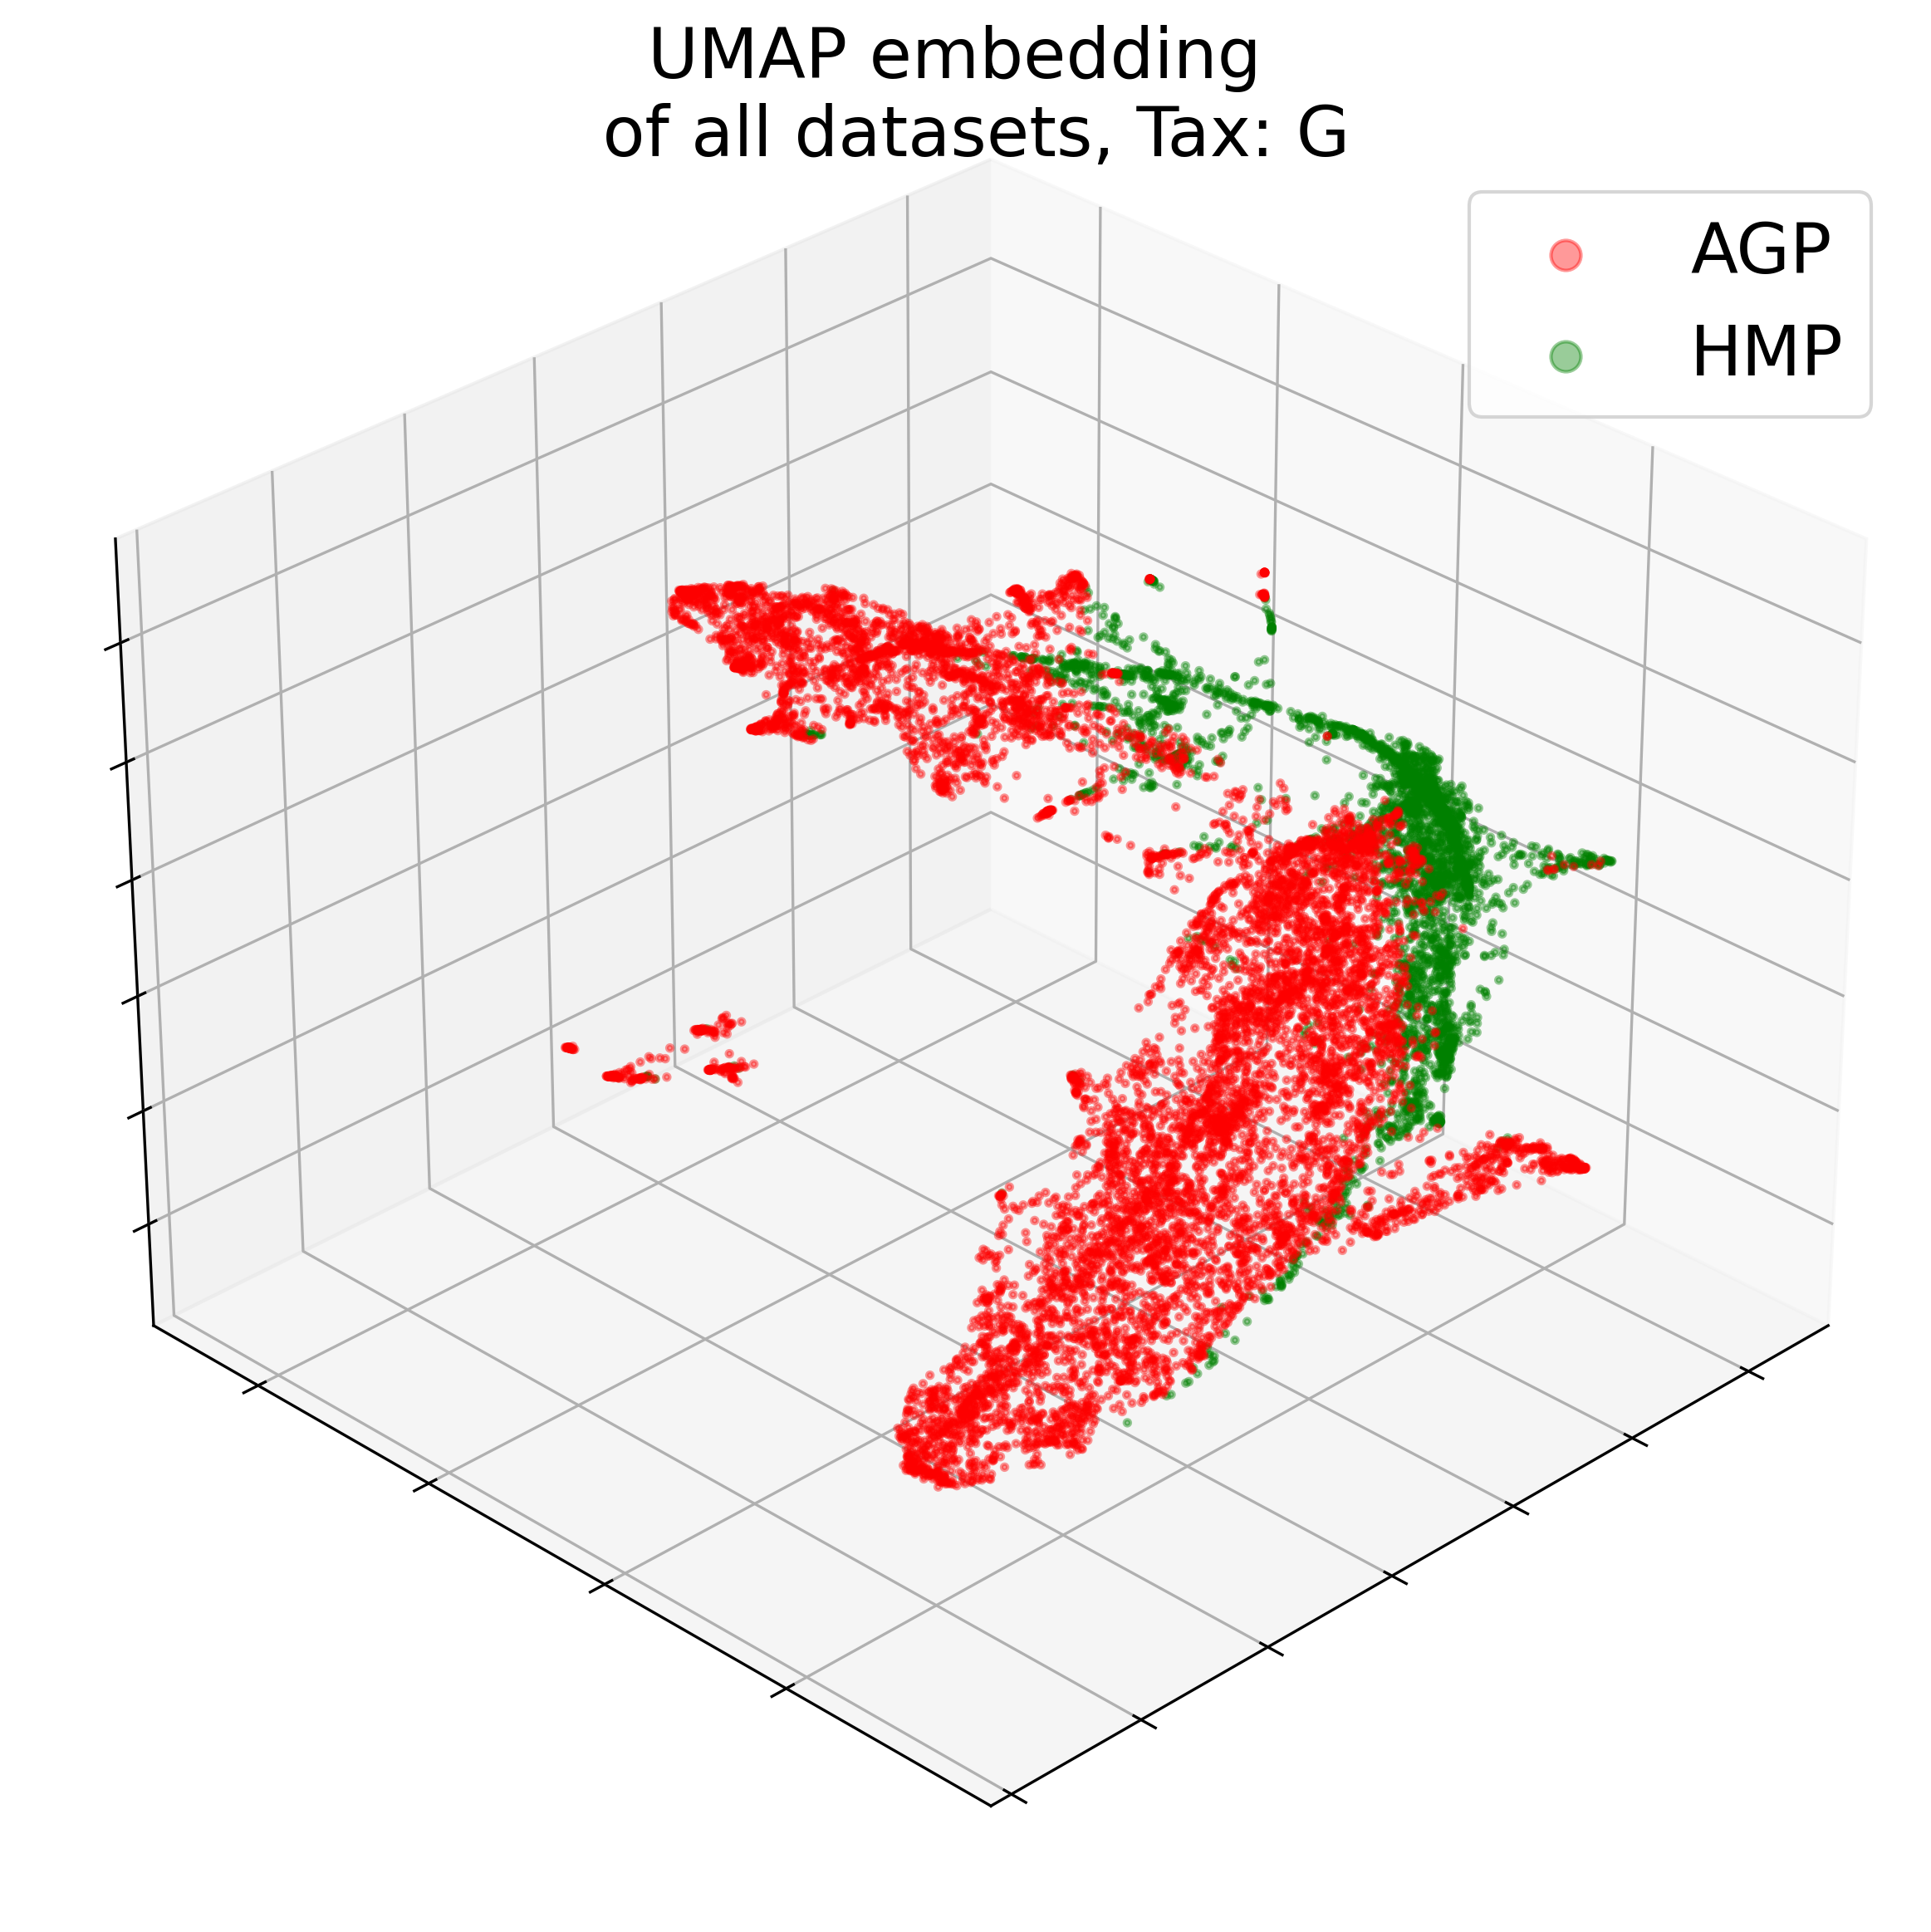

In [8]:
fig = plt.figure(figsize=(10,10), dpi=300) 
ax = plt.axes(projection ="3d")
Z = Z_umap
AGP_mask = np.arange(Z.shape[0]) < 9511
ax.scatter3D(Z[:, 0][AGP_mask], Z[:, 1][AGP_mask], Z[:, 2][AGP_mask], color = 'red', s = 3, label='AGP', alpha=0.4)
ax.scatter3D(Z[:, 0][~AGP_mask], Z[:, 1][~AGP_mask], Z[:, 2][~AGP_mask], color = 'green', s = 3, label='HMP',alpha=0.4)
plt.title(f"UMAP embedding \n of all datasets, Tax: {tax.capitalize()}", fontsize=20)
plt.legend(markerscale=5, bbox_to_anchor=(1.0, 0.93))
ax.set_zticklabels([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True)
ax.view_init(azim=45)
plt.show()